<a href="https://colab.research.google.com/github/Nawapon19/ML-Practice/blob/main/Sign_Language_Recognition_System_using_TensorFlow_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sign Language Recognition System using TensorFlow**

For Sign language recognition let’s use the Sign Language MNIST dataset. It has images of signs corresponding to each alphabet in the English language. Since the sign language of J and Z requires motion, those two classes are not available in the dataset.

**Importing Libraries**

In [1]:
import string
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Importing Dataset**

The dataset is available as two CSV files, sign_mnist_train.csv and sign_mnist_test.csv.
* Each row in the CSV file is a training sample with the 0th index column having the labels from 0-25
* The rest of the column containing the 784-pixel values of a 28 x 28 image.
* Each pixel value will be in the range [0, 255].

In [40]:
# load dataset to pandas dataframe
df = pd.read_csv('sign_mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [41]:
df['label'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

**Data Loading and Preprocessing**

The dataset has been provided in two files one is for training and the other one is for testing.
* load this data and then one hot encode the labels
* consider the fact not building the classifier for ‘J’ and ‘Z’ alphabet.

In [42]:
# define a function to load and preprocess the data
def load_data(path):
  # load data to pandas dataframe
  df = pd.read_csv(path)

  # create an array for labels -> y
  # re-label the letter k - y from 10 - 24 to 9 - 23
  y = np.array([label if label < 9 else label - 1 for label in df['label']])

  # drop the label column for creating input array
  df = df.drop('label', axis = 1)
  # create a array for input data x
  # reshape to 28x28 for 784 pixel image
  # expand dimension to axis = 3
  # 784:[x...x] -> 28*28:[[x...x][x...x][x...x]] -> 28*28*1[[[x]...[x]][[x]...[x]][[x]...[x]]]
  x = np.array([df.iloc[i].to_numpy().reshape((28, 28)) for i in range(len(df))]).astype(float)
  x = np.expand_dims(x, axis = 3)

  # convert categorical variable into dummy/indicator variables (True/False)
  y = pd.get_dummies(y).values

  return x, y

In [43]:
# load and preprocess data for training and testing
X_train, Y_train = load_data('sign_mnist_train.csv')
X_test, Y_test = load_data('sign_mnist_test.csv')

In [45]:
# check the shape of training and testing data
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(27455, 28, 28, 1) (27455, 24)
(7172, 28, 28, 1) (7172, 24)


**Data Visualization**

* visualize images for signs of some of the alphabets

In [48]:
string.ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

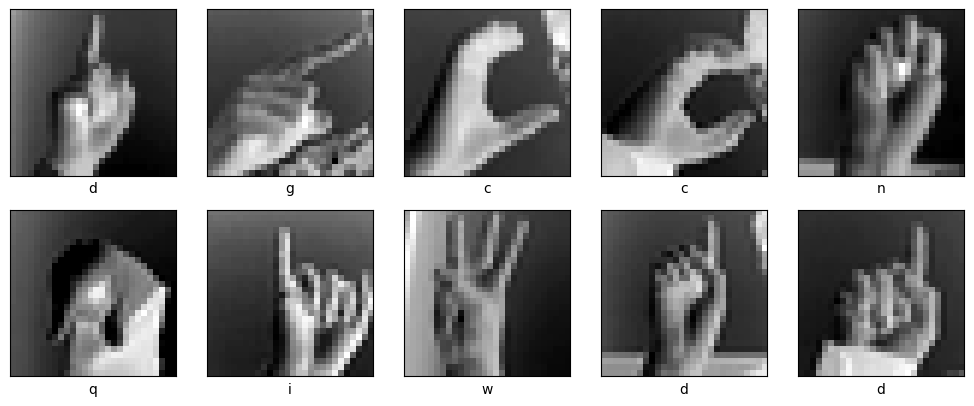

In [50]:
# create a list of class name (a...ik...y)
class_names = list(string.ascii_lowercase[:26].replace('j', '').replace('z', ''))

# plot the first 10 images
plt.figure(figsize = (10, 10))
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  # squeeze: remove axes of length one
  # 28*28*1 -> 28*28
  plt.imshow(X_train[i].squeeze(), cmap = plt.cm.binary)
  # argmax: returns the indices of the maximum values along an axis
  # return indices of True(1) of all row, then take the ith row to map with class name
  plt.xlabel(class_names[np.argmax(Y_train, axis = 1)[i]])

plt.tight_layout()
plt.show()

**Model Development**
* use the TensorFlow library to build CNN model

Keras framework of the tensor flow library contains all the functionalities that one may need to define the architecture of a Convolutional Neural Network and train it on the data.

**Model Architecture**

Implement a Sequential model which will contain the following parts:
* Two Convolutional Layers followed by MaxPooling Layers.
* The Flatten layer to flatten the output of the convolutional layer.
* A fully connected layers followed by the output of the flattened layer.
* BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting
* The output layer which outputs soft probabilities for the 24 classes


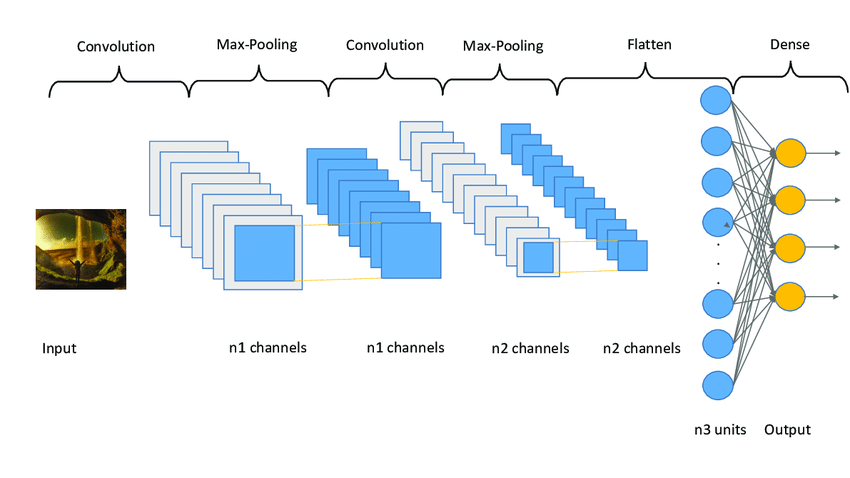

In [68]:
# build the model
model = tf.keras.models.Sequential([
    # A 2-D convolutional layer applies sliding convolutional filters to 2-D input
    tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3, 3),
                           activation = 'relu',
                           input_shape = (28, 28, 1)),
    #A 2-D max pooling layer performs downsampling by dividing the input into rectangular pooling regions,
    # then computing the maximum of each region.
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3, 3),
                           activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3, 3),
                           activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # A flatten layer collapses the spatial dimensions of the input into the channel dimension.
    tf.keras.layers.Flatten(),
    # A batch normalization layer normalizes a mini-batch of data across all observations for each channel independently.
    # tf.keras.layers.BatchNormalization(),
    # A fully connected layer multiplies the input by a weight matrix and then adds a bias vector.
    tf.keras.layers.Dense(128, activation = 'relu'),
    # A dropout layer randomly sets input elements to zero with a given probability.
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(24, activation = 'softmax')
])

In [69]:
# print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 1, 1, 64)         

In [70]:
# compile the model with essential parameters
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [71]:
# train the model with training data
history = model.fit(X_train, Y_train,
                    validation_data = (X_test, Y_test),
                    epochs = 5,
                    verbose = 1)

Epoch 1/5
858/858 [==============================] - 45s 51ms/step - loss: 1.3805 - accuracy: 0.5867 - val_loss: 0.5950 - val_accuracy: 0.8122
Epoch 2/5
858/858 [==============================] - 44s 51ms/step - loss: 0.1386 - accuracy: 0.9530 - val_loss: 0.4698 - val_accuracy: 0.8791
Epoch 3/5
858/858 [==============================] - 44s 52ms/step - loss: 0.0694 - accuracy: 0.9764 - val_loss: 0.5025 - val_accuracy: 0.8837
Epoch 4/5
858/858 [==============================] - 43s 50ms/step - loss: 0.0486 - accuracy: 0.9847 - val_loss: 0.6066 - val_accuracy: 0.8689
Epoch 5/5
858/858 [==============================] - 45s 52ms/step - loss: 0.0498 - accuracy: 0.9836 - val_loss: 0.8134 - val_accuracy: 0.8553


**Model Evaluation**

* visualize the training and validation accuracy with each epoch

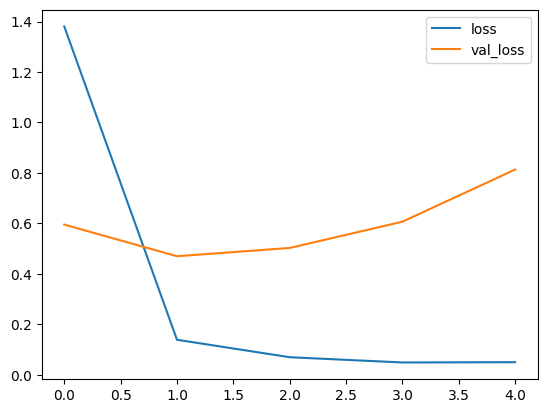

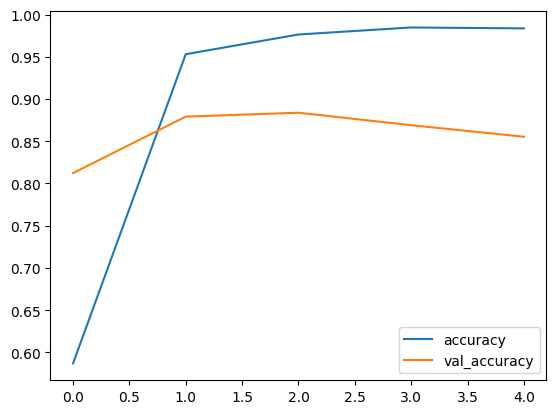

In [72]:
# load history of model training to pandas dataframe
history_df = pd.DataFrame(history.history)

# plot training loss and validation loss for each epoch
history_df.loc[:,['loss', 'val_loss']].plot()

# plot training accuracy and validation accuracy for each epoch
history_df.loc[:,['accuracy', 'val_accuracy']].plot()

plt.show()

In [73]:
# evaluate the model using test data
model.evaluate(X_test, Y_test)

225/225 [==============================] - 3s 13ms/step - loss: 0.8134 - accuracy: 0.8553


[0.8134297132492065, 0.855270504951477]

In [79]:
# build the model
model2 = tf.keras.models.Sequential([
    # A 2-D convolutional layer applies sliding convolutional filters to 2-D input
    tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3, 3),
                           activation = 'relu',
                           input_shape = (28, 28, 1)),
    #A 2-D max pooling layer performs downsampling by dividing the input into rectangular pooling regions,
    # then computing the maximum of each region.
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3, 3),
                           activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3, 3),
                           activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # A flatten layer collapses the spatial dimensions of the input into the channel dimension.
    tf.keras.layers.Flatten(),
    # A batch normalization layer normalizes a mini-batch of data across all observations for each channel independently.
    # tf.keras.layers.BatchNormalization(),
    # A fully connected layer multiplies the input by a weight matrix and then adds a bias vector.
    tf.keras.layers.Dense(128, activation = 'relu'),
    # A dropout layer randomly sets input elements to zero with a given probability.
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(24, activation = 'softmax')
])

# compile the model with essential parameters
model2.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [80]:
history_25 = model2.fit(X_train, Y_train,
                    validation_data = (X_test, Y_test),
                    epochs = 25,
                    verbose = 1)

Epoch 1/25
858/858 [==============================] - 45s 51ms/step - loss: 2.0266 - accuracy: 0.3650 - val_loss: 0.7958 - val_accuracy: 0.7358
Epoch 2/25
858/858 [==============================] - 47s 55ms/step - loss: 0.2252 - accuracy: 0.9244 - val_loss: 0.5491 - val_accuracy: 0.8681
Epoch 3/25
858/858 [==============================] - 46s 53ms/step - loss: 0.0665 - accuracy: 0.9781 - val_loss: 0.5807 - val_accuracy: 0.8476
Epoch 4/25
858/858 [==============================] - 45s 52ms/step - loss: 0.0397 - accuracy: 0.9876 - val_loss: 0.5990 - val_accuracy: 0.8769
Epoch 5/25
858/858 [==============================] - 43s 50ms/step - loss: 0.0466 - accuracy: 0.9844 - val_loss: 0.4675 - val_accuracy: 0.8933
Epoch 6/25
858/858 [==============================] - 42s 49ms/step - loss: 0.0372 - accuracy: 0.9893 - val_loss: 0.6436 - val_accuracy: 0.8839
Epoch 7/25
858/858 [==============================] - 43s 50ms/step - loss: 0.0338 - accuracy: 0.9895 - val_loss: 0.7359 - val_accuracy:

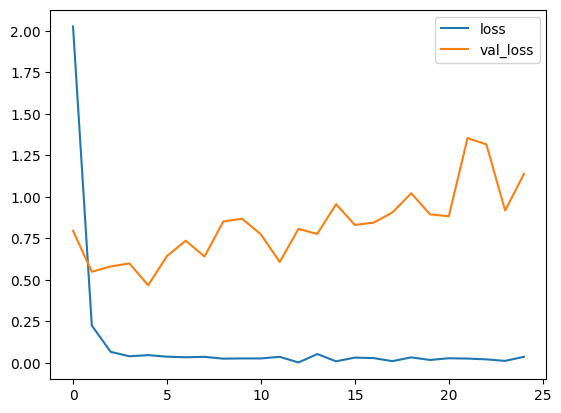

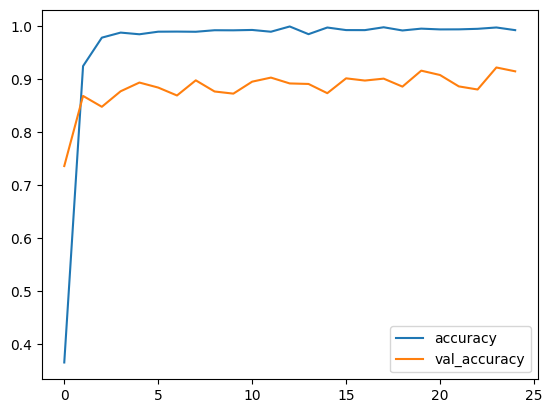

In [81]:
# load history of model training to pandas dataframe
history_25_df = pd.DataFrame(history_25.history)

# plot training loss and validation loss for each epoch
history_25_df.loc[:,['loss', 'val_loss']].plot()

# plot training accuracy and validation accuracy for each epoch
history_25_df.loc[:,['accuracy', 'val_accuracy']].plot()

plt.show()

In [82]:
# evaluate the model using test data
model2.evaluate(X_test, Y_test)

225/225 [==============================] - 3s 15ms/step - loss: 1.1381 - accuracy: 0.9145


[1.1380724906921387, 0.9145287275314331]